# Old Method : Keeping for reference

In [1]:
from forge.core.database import DatabaseManager
from forge.analysis.composition import CompositionAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml

# 1. Connect to AWS database
db_config = {
    'database': {
        'dbname': 'test_database',
        'user': 'myless',
        'password': 'vcrtiwzr',
        'host': 'database-vcrtiwzr.cfg4i4qmuc4m.us-east-1.rds.amazonaws.com',
        'port': 5432
    }
}

db_manager = DatabaseManager(config_dict=db_config)



/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Get unique compositions directly from database
print("Fetching unique compositions from database...")
with db_manager.conn.cursor() as cur:
    cur.execute("""
        SELECT DISTINCT composition 
        FROM structures
        WHERE composition IS NOT NULL
    """)
    rows = cur.fetchall()

# Convert JSON compositions to dictionaries of atomic fractions
compositions = []
for row in rows:
    comp_json = row[0]  # Get the composition JSON
    # Convert counts to fractions
    total_atoms = sum(data['num_atoms'] for data in comp_json.values())
    comp_dict = {
        element: data['num_atoms'] / total_atoms 
        for element, data in comp_json.items()
    }
    compositions.append(comp_dict)

print(f"Found {len(compositions)} unique compositions")

Fetching unique compositions from database...
Found 197 unique compositions


In [3]:
# 3. Initialize and run composition analysis
analyzer = CompositionAnalyzer(n_components=3, random_state=42, dim_method='UMAP', cluster_method='DBSCAN')

print("Running UMAP and DBSCAN analysis...")
embeddings, clusters = analyzer.analyze_compositions(compositions, n_clusters=5)

Running UMAP and DBSCAN analysis...


/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [4]:
# 4. Generate new compositions within constraints
print("Generating new composition suggestions...")
new_compositions = analyzer.suggest_new_compositions(
    compositions,
    n_suggestions=10,
    constraints={
        'V': (0.8, 0.95),      # V must be between 70-100%
        'Cr': (0.0, 0.1),     # Cr, Ti, W, Zr each must be between 0-30%
        'Ti': (0.0, 0.1),
        'W': (0.0, 0.1),
        'Zr': (0.0, 0.02)
    }
)


Generating new composition suggestions...


In [8]:
print(new_compositions)

[]


In [5]:
# 5. Visualize results
#fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111, projection='3d')

# Combine original and new compositions for t-SNE
all_compositions = compositions + new_compositions
print(f"Total compositions for {analyzer.dim_method}: {len(all_compositions)}")

# Convert all compositions to array format
all_comp_array = analyzer._compositions_to_array(all_compositions)
print(f"Combined composition array shape: {all_comp_array.shape}")

# Run t-SNE on all compositions together
all_embeddings = analyzer.tsne.fit_transform(all_comp_array)
print(f"Combined embeddings shape: {all_embeddings.shape}")

# Split embeddings back into original and new
original_embeddings = all_embeddings[:len(compositions)]
new_embeddings = all_embeddings[len(compositions):]

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Calculate statistics for each dimension
mean = np.mean(all_embeddings, axis=0)
std = np.std(all_embeddings, axis=0)
n_std = 2  # Number of standard deviations to consider as threshold

# Create masks for outliers
mask_original = np.all(np.abs(original_embeddings - mean) < n_std * std, axis=1)
mask_new = np.all(np.abs(new_embeddings - mean) < n_std * std, axis=1)

# Create the 3D scatter plot
fig = go.Figure()

# Plot original compositions with their clusters (filtered)
fig.add_trace(go.Scatter3d(
    x=original_embeddings[mask_original, 0],
    y=original_embeddings[mask_original, 1],
    z=original_embeddings[mask_original, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=np.array(clusters)[mask_original],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Cluster')
    ),
    text=[f"Cluster {c}<br>" + "<br>".join([f"{k}: {v:.3f}" for k, v in comp.items()]) 
          for c, comp in zip(np.array(clusters)[mask_original], np.array(compositions)[mask_original])],
    hoverinfo='text',
    name='Existing'
))

# Plot new compositions in red (filtered)
fig.add_trace(go.Scatter3d(
    x=new_embeddings[mask_new, 0],
    y=new_embeddings[mask_new, 1],
    z=new_embeddings[mask_new, 2],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        symbol='diamond'
    ),
    text=["Suggested<br>" + "<br>".join([f"{k}: {v:.3f}" for k, v in comp.items()]) 
          for comp in np.array(new_compositions)[mask_new]],
    hoverinfo='text',
    name='Suggested'
))

# Update the layout
fig.update_layout(
    title=f'Interactive Composition Space Analysis ({analyzer.dim_method})',
    scene=dict(
        xaxis_title=f'{analyzer.dim_method} 1',
        yaxis_title=f'{analyzer.dim_method} 2',
        zaxis_title=f'{analyzer.dim_method} 3'
    ),
    width=1000,
    height=800,
    showlegend=True
)

# Show the plot
fig.show()

Total compositions for UMAP: 197
Combined composition array shape: (197, 5)


AttributeError: 'CompositionAnalyzer' object has no attribute 'tsne'

In [ ]:
# 6. Print suggested compositions
print("\nSuggested new compositions:")
for i, comp in enumerate(new_compositions, 1):
    print(f"\nComposition {i}:")
    for element, fraction in comp.items():
        print(f"  {element}: {fraction:.3f}")


Suggested new compositions:

Composition 1:
  Cr: 0.025
  Ti: 0.048
  V: 0.891
  W: 0.023
  Zr: 0.014

Composition 2:
  Cr: 0.020
  Ti: 0.039
  V: 0.910
  W: 0.018
  Zr: 0.012

Composition 3:
  Cr: 0.036
  Ti: 0.068
  V: 0.847
  W: 0.033
  Zr: 0.017

Composition 4:
  Cr: 0.020
  Ti: 0.019
  V: 0.926
  W: 0.015
  Zr: 0.020

Composition 5:
  Cr: 0.016
  Ti: 0.016
  V: 0.939
  W: 0.012
  Zr: 0.017

Composition 6:
  Cr: 0.015
  Ti: 0.016
  V: 0.941
  W: 0.012
  Zr: 0.016

Composition 7:
  Cr: 0.017
  Ti: 0.017
  V: 0.935
  W: 0.013
  Zr: 0.017

Composition 8:
  Cr: 0.019
  Ti: 0.018
  V: 0.930
  W: 0.014
  Zr: 0.019

Composition 9:
  Cr: 0.017
  Ti: 0.034
  V: 0.922
  W: 0.016
  Zr: 0.011

Composition 10:
  Cr: 0.028
  Ti: 0.054
  V: 0.878
  W: 0.026
  Zr: 0.015

Composition 11:
  Cr: 0.043
  Ti: 0.080
  V: 0.820
  W: 0.039
  Zr: 0.019

Composition 12:
  Cr: 0.043
  Ti: 0.079
  V: 0.820
  W: 0.039
  Zr: 0.019

Composition 13:
  Cr: 0.044
  Ti: 0.082
  V: 0.814
  W: 0.040
  Zr: 0.020

Comp

## Identify Diverse Compositions

In [ ]:
# After generating new compositions and running t-SNE
diverse_indices, fig = analyzer.plot_with_diverse_points(
    embeddings=original_embeddings,
    clusters=clusters,
    new_embeddings=new_embeddings,
    new_compositions=new_compositions,  # Added this parameter
    n_diverse=9,
    method='maximin',
    constraints={  # Same constraints format as suggest_new_compositions
        'V': (0.8, 0.95),
        'Cr': (0.0, 0.1),
        'Ti': (0.0, 0.1),
        'W': (0.0, 0.1),
        'Zr': (0.0, 0.02)
    }
)

# Show the plot
fig.show()

# Get the actual diverse compositions that meet the constraints
diverse_compositions = [new_compositions[i] for i in diverse_indices]

In [ ]:
# print the diverse compositions
for comp in diverse_compositions:
    print(comp)

{'Cr': 0.013373414212928328, 'Ti': 0.014788932465369891, 'V': 0.9467249862178287, 'W': 0.010368891762719275, 'Zr': 0.014743775341153781}
{'Cr': 0.04423136919532518, 'Ti': 0.08248368181451626, 'V': 0.8133508459881773, 'W': 0.04005863704679293, 'Zr': 0.019875465955188326}
{'Cr': 0.024133186898942546, 'Ti': 0.046717070994614016, 'V': 0.8937253206938747, 'W': 0.022132737850564285, 'Zr': 0.013291683562004553}
{'Cr': 0.017134575187472904, 'Ti': 0.03426238142754815, 'V': 0.9217134109441932, 'W': 0.015890561010724877, 'Zr': 0.010999071430060821}
{'Cr': 0.033641589706794775, 'Ti': 0.06363817051158509, 'V': 0.8557003456139715, 'W': 0.030613438629229946, 'Zr': 0.016406455538418754}
{'Cr': 0.0193740441463256, 'Ti': 0.018899343601009977, 'V': 0.9278521292216015, 'W': 0.014607218567000684, 'Zr': 0.019267264464062357}
{'Cr': 0.013373437838920022, 'Ti': 0.027569082809687465, 'V': 0.9367545442281882, 'W': 0.012535940777955636, 'Zr': 0.009766994345248765}
{'Cr': 0.028055152048390326, 'Ti': 0.05369657785

## Use other clustering methods and compare

In [ ]:
def analyze_composition_space(compositions, 
                            n_components=3,
                            dim_method='t-SNE',
                            cluster_method='KMeans',
                            n_clusters=5,
                            n_suggestions=100,
                            constraints=None,
                            n_diverse=5,
                            random_state=42):
    """
    Analyze composition space using specified methods and visualize results.
    
    Args:
        compositions (List[Dict]): List of composition dictionaries
        n_components (int): Number of dimensions (2 or 3)
        dim_method (str): Dimensionality reduction method ('t-SNE', 'PCA', 'MDS', 'UMAP')
        cluster_method (str): Clustering method ('KMeans', 'AGGLOMERATIVE', 'SPECTRAL', 'DBSCAN')
        n_clusters (int): Number of clusters
        n_suggestions (int): Number of new compositions to suggest
        constraints (Dict): Composition constraints dictionary
        n_diverse (int): Number of diverse points to identify
        random_state (int): Random seed
    
    Returns:
        tuple: (analyzer, embeddings, clusters, new_compositions, diverse_indices, fig)
    """
    # Initialize analyzer
    analyzer = CompositionAnalyzer(
        n_components=n_components,
        random_state=random_state,
        dim_method=dim_method,
        cluster_method=cluster_method
    )
    
    # Run analysis
    print(f"Running {dim_method} and {cluster_method} analysis...")
    embeddings, clusters = analyzer.analyze_compositions(
        compositions, 
        n_clusters=n_clusters
    )
    
    # Generate new compositions
    print("Generating new composition suggestions...")
    new_compositions = analyzer.suggest_new_compositions(
        compositions,
        n_suggestions=n_suggestions,
        constraints=constraints
    )
    
    # Analyze combined compositions
    all_compositions = compositions + new_compositions
    all_embeddings, _ = analyzer.analyze_compositions(
        all_compositions, 
        n_clusters=n_clusters
    )
    
    # Split embeddings
    original_embeddings = all_embeddings[:len(compositions)]
    new_embeddings = all_embeddings[len(compositions):]
    
    # Find diverse points and create visualization
    diverse_indices, fig = analyzer.plot_with_diverse_points(
        embeddings=original_embeddings,
        clusters=clusters,
        new_embeddings=new_embeddings,
        new_compositions=new_compositions,
        n_diverse=n_diverse,
        method='maximin',
        constraints=constraints
    )
    
    return analyzer, embeddings, clusters, new_compositions, diverse_indices, fig

def compare_composition_methods(compositions,
                              dim_methods=None,
                              cluster_methods=None,
                              n_components=2,
                              n_clusters=5,
                              save_path=None,
                              random_state=42):
    """
    Compare different dimensionality reduction and clustering methods.
    
    Args:
        compositions (List[Dict]): List of composition dictionaries
        dim_methods (List[str]): List of dimensionality reduction methods
        cluster_methods (List[str]): List of clustering methods
        n_components (int): Number of dimensions
        n_clusters (int): Number of clusters
        save_path (str): Path to save comparison plot
        random_state (int): Random seed
    
    Returns:
        tuple: (analyzer, scores, fig)
    """
    analyzer = CompositionAnalyzer(
        n_components=n_components,
        random_state=random_state
    )
    
    scores = analyzer.compare_methods(
        compositions,
        dim_methods=dim_methods,
        cluster_methods=cluster_methods,
        n_clusters=n_clusters,
        save_path=save_path
    )
    
    return analyzer, scores

diverse_compositions = [{'Cr': 0.013373414212928328, 'Ti': 0.014788932465369891, 'V': 0.9467249862178287, 'W': 0.010368891762719275, 'Zr': 0.014743775341153781},
{'Cr': 0.04423136919532518, 'Ti': 0.08248368181451626, 'V': 0.8133508459881773, 'W': 0.04005863704679293, 'Zr': 0.019875465955188326},
{'Cr': 0.024133186898942546, 'Ti': 0.046717070994614016, 'V': 0.8937253206938747, 'W': 0.022132737850564285, 'Zr': 0.013291683562004553},
{'Cr': 0.017134575187472904, 'Ti': 0.03426238142754815, 'V': 0.9217134109441932, 'W': 0.015890561010724877, 'Zr': 0.010999071430060821},
{'Cr': 0.033641589706794775, 'Ti': 0.06363817051158509, 'V': 0.8557003456139715, 'W': 0.030613438629229946, 'Zr': 0.016406455538418754},
{'Cr': 0.0193740441463256, 'Ti': 0.018899343601009977, 'V': 0.9278521292216015, 'W': 0.014607218567000684, 'Zr': 0.019267264464062357},
{'Cr': 0.013373437838920022, 'Ti': 0.027569082809687465, 'V': 0.9367545442281882, 'W': 0.012535940777955636, 'Zr': 0.009766994345248765},
{'Cr': 0.028055152048390326, 'Ti': 0.053696577851548334, 'V': 0.878041022280597, 'W': 0.025630803042896454, 'Zr': 0.014576444776567828},
{'Cr': 0.02041086717761434, 'Ti': 0.04009285200522037, 'V': 0.9086112187256713, 'W': 0.018812739697663013, 'Zr': 0.012072322393831037}]

# Example usage:
# Single analysis
analyzer, embeddings, clusters, new_comps, diverse_idx, fig = analyze_composition_space(
    compositions,
    n_components=3,
    dim_method='PCA',
    cluster_method='KMeans',
    constraints={
        'V': (0.8, 0.95),
        'Cr': (0.0, 0.1),
        'Ti': (0.0, 0.1),
        'W': (0.0, 0.1),
        'Zr': (0.0, 0.02)
    },
    n_diverse=9
)
fig.show()

Running PCA and KMeans analysis...
Generating new composition suggestions...


In [ ]:
# Method comparison
analyzer, scores = compare_composition_methods(
    compositions,
    dim_methods=['TSNE', 'PCA', 'MDS', 'UMAP'],
    cluster_methods=['KMEANS', 'DBSCAN', 'SPECTRAL'],
    save_path='./scratch/data/composition_space_comparison.png'
)


/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
def analyze_new_compositions(analyzer, 
                           existing_compositions, 
                           new_compositions,
                           n_clusters=5,
                           plot_type='3d'):
    """
    Analyze how new compositions fit into existing composition space.
    
    Args:
        analyzer: Initialized CompositionAnalyzer
        existing_compositions: List of existing composition dictionaries
        new_compositions: List of new composition dictionaries to analyze
        n_clusters: Number of clusters for visualization
        plot_type: Either '3d' or '2d'
    
    Returns:
        tuple: (embeddings, new_embeddings, distances_from_centroid, fig)
    """
    # Get embeddings for existing compositions
    embeddings, clusters = analyzer.analyze_compositions(
        existing_compositions, 
        n_clusters=n_clusters
    )
    
    # Calculate centroid of existing composition space
    centroid = np.mean(embeddings, axis=0)
    
    # Convert new compositions to array format
    all_compositions = existing_compositions + new_compositions
    
    # Get embeddings for all compositions
    all_embeddings, _ = analyzer.analyze_compositions(
        all_compositions,
        n_clusters=n_clusters
    )
    
    # Split embeddings
    new_embeddings = all_embeddings[len(existing_compositions):]
    
    # Calculate L2 distances from centroid
    distances_from_centroid = np.linalg.norm(new_embeddings - centroid, axis=1)
    
    # Create visualization
    import plotly.graph_objects as go
    
    fig = go.Figure()
    
    # Plot existing compositions
    fig.add_trace(go.Scatter3d(
        x=embeddings[:, 0],
        y=embeddings[:, 1],
        z=embeddings[:, 2],
        mode='markers',
        marker=dict(
            size=6,
            color=clusters,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title='Cluster')
        ),
        name='Existing'
    ))
    
    # Plot centroid
    fig.add_trace(go.Scatter3d(
        x=[centroid[0]],
        y=[centroid[1]],
        z=[centroid[2]],
        mode='markers',
        marker=dict(
            size=15,
            color='yellow',
            symbol='x'
        ),
        name='Centroid'
    ))
    
    # Plot new compositions
    fig.add_trace(go.Scatter3d(
        x=new_embeddings[:, 0],
        y=new_embeddings[:, 1],
        z=new_embeddings[:, 2],
        mode='markers',
        marker=dict(
            size=10,
            color=distances_from_centroid,
            colorscale='Reds',
            showscale=True,
            colorbar=dict(title='Distance from Centroid')
        ),
        text=[f"Composition {i}<br>Distance: {dist:.2f}<br>" + 
              "<br>".join([f"{k}: {v:.3f}" for k, v in comp.items()])
              for i, (comp, dist) in enumerate(zip(new_compositions, distances_from_centroid))],
        hoverinfo='text',
        name='New Compositions'
    ))
    
    # Update layout
    fig.update_layout(
        title=f'Composition Space Analysis with New Points ({analyzer.dim_method})',
        scene=dict(
            xaxis_title=f'{analyzer.dim_method} 1',
            yaxis_title=f'{analyzer.dim_method} 2',
            zaxis_title=f'{analyzer.dim_method} 3'
        ),
        width=1000,
        height=800,
        showlegend=True
    )
    
    return embeddings, new_embeddings, distances_from_centroid, fig


actually_run_compositions = [{'Cr': 0.04, 'Ti': 0.04, 'V': 0.92, 'W': 0.0, 'Zr': 0.0},
                             {'Cr' : 0.015625, 'Ti' : 0.015625, 'V' : 0.9375, 'W' : 0.015625, 'Zr' : 0.015625},
                             {'Cr' : 0.03125, 'Ti' : 0.0546875, 'V' : 0.8671875, 'W' : 0.03125, 'Zr' : 0.015625},
                             {'Cr' : 0.046875, 'Ti' : 0.0859375, 'V' : 0.796875, 'W' : 0.046875, 'Zr' : 0.0234375}]

# Usage:
# create new analyzer
# Initialize analyzer
n_components = 3
random_state = 42
dim_method = 'MDS'
cluster_method = 'KMEANS'
analyzer = CompositionAnalyzer(
        n_components=n_components,
        random_state=random_state,
        dim_method=dim_method,
        cluster_method=cluster_method
    )
embeddings, new_embeddings, distances, fig = analyze_new_compositions(
    analyzer=analyzer,  # Your existing analyzer
    existing_compositions=compositions,  # Your existing compositions
    new_compositions=actually_run_compositions,  # Your 4 new compositions
    n_clusters=5
)

# Show the plot
fig.show()

# Print distances from centroid
print("\nDistances from centroid:")
for i, (comp, dist) in enumerate(zip(actually_run_compositions, distances)):
    print(f"\nComposition {i}:")
    for element, fraction in comp.items():
        print(f"  {element}: {fraction:.3f}")
    print(f"Distance from centroid: {dist:.3f}")


Distances from centroid:

Composition 0:
  Cr: 0.040
  Ti: 0.040
  V: 0.920
  W: 0.000
  Zr: 0.000
Distance from centroid: 0.155

Composition 1:
  Cr: 0.016
  Ti: 0.016
  V: 0.938
  W: 0.016
  Zr: 0.016
Distance from centroid: 0.169

Composition 2:
  Cr: 0.031
  Ti: 0.055
  V: 0.867
  W: 0.031
  Zr: 0.016
Distance from centroid: 0.096

Composition 3:
  Cr: 0.047
  Ti: 0.086
  V: 0.797
  W: 0.047
  Zr: 0.023
Distance from centroid: 0.049



Distance Statistics:
Existing Compositions:
  Mean distance: 0.153
  Median distance: 0.117
  Std distance: 0.102

New Compositions:

Composition 0: {'Cr': 0.04, 'Ti': 0.04, 'V': 0.92, 'W': 0.0, 'Zr': 0.0}
  Distance: 0.155 (percentile: 68.8%)
  LOF Score: 1.069

Composition 1: {'Cr': 0.015625, 'Ti': 0.015625, 'V': 0.9375, 'W': 0.015625, 'Zr': 0.015625}
  Distance: 0.169 (percentile: 71.2%)
  LOF Score: 1.206

Composition 2: {'Cr': 0.03125, 'Ti': 0.0546875, 'V': 0.8671875, 'W': 0.03125, 'Zr': 0.015625}
  Distance: 0.096 (percentile: 28.8%)
  LOF Score: 2.095

Composition 3: {'Cr': 0.046875, 'Ti': 0.0859375, 'V': 0.796875, 'W': 0.046875, 'Zr': 0.0234375}
  Distance: 0.049 (percentile: 3.1%)
  LOF Score: 0.994


/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_18884/3443435118.py:187: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



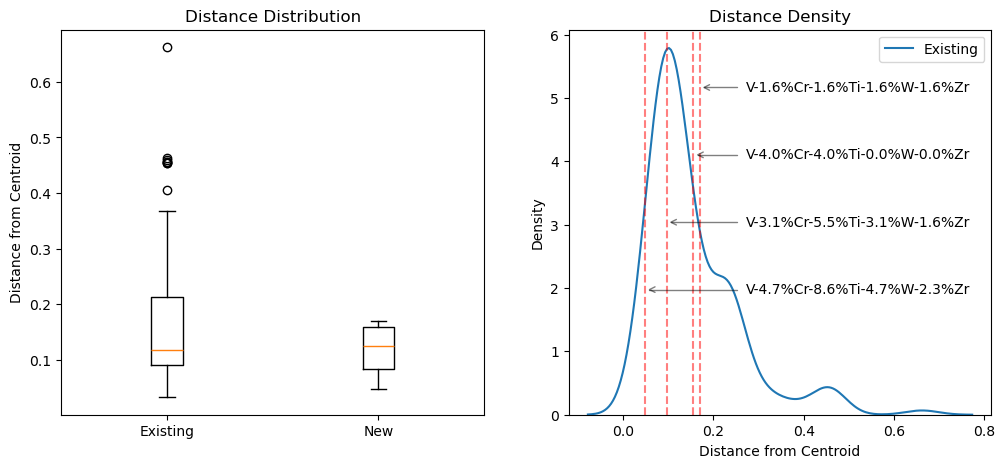

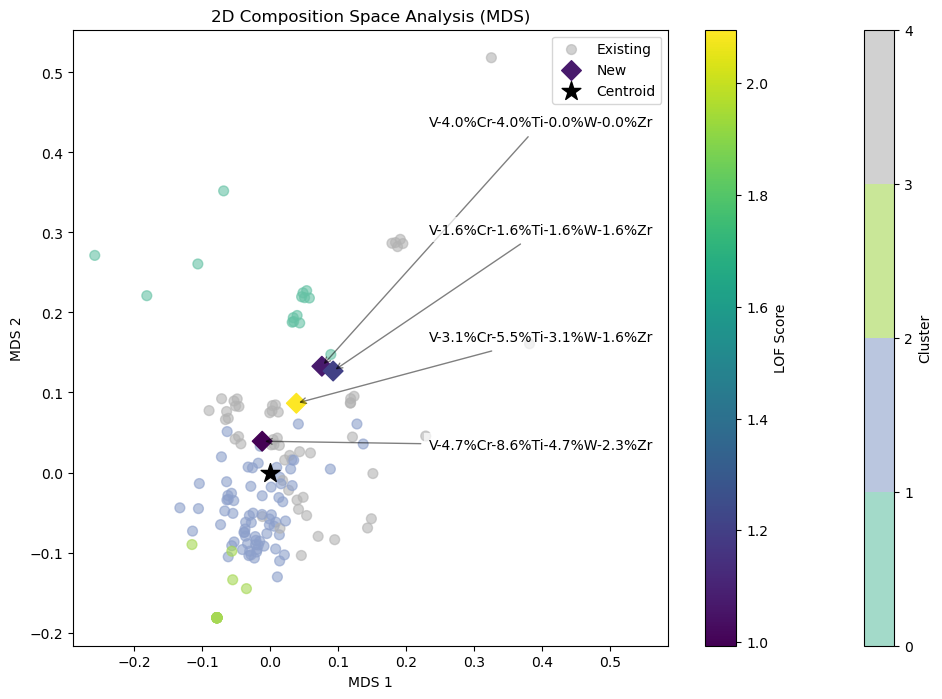

<Figure size 640x480 with 0 Axes>

In [ ]:
def analyze_composition_distribution(analyzer,
                                  existing_compositions,
                                  new_compositions,
                                  n_clusters=5,
                                  n_neighbors=5,
                                  plot_type='both'):
    """
    Comprehensive analysis of new compositions' distribution in composition space.
    
    Args:
        analyzer: Initialized CompositionAnalyzer
        existing_compositions: List of existing composition dictionaries
        new_compositions: List of new composition dictionaries
        n_clusters: Number of clusters for visualization
        n_neighbors: Number of neighbors for density estimation
        plot_type: One of 'both', '2d', or '3d'
    """
    from sklearn.neighbors import LocalOutlierFactor
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.express as px
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    string_new_compositions = []
    for comp in new_compositions:
        string_comp = "V-{:.1f}%Cr-{:.1f}%Ti-{:.1f}%W-{:.1f}%Zr".format(
            comp.get('Cr', 0) * 100, comp.get('Ti', 0) * 100, comp.get('W', 0) * 100, 
            comp.get('Zr', 0) * 100
        )
        string_new_compositions.append(string_comp)
        
    
    # Get embeddings
    embeddings, clusters = analyzer.analyze_compositions(
        existing_compositions, 
        n_clusters=n_clusters
    )
    
    # Get embeddings for new compositions
    all_compositions = existing_compositions + new_compositions
    all_embeddings, _ = analyzer.analyze_compositions(all_compositions)
    new_embeddings = all_embeddings[len(existing_compositions):]
    
    # Calculate centroid and distances
    centroid = np.mean(embeddings, axis=0)
    existing_distances = np.linalg.norm(embeddings - centroid, axis=1)
    new_distances = np.linalg.norm(new_embeddings - centroid, axis=1)
    
    # Calculate LOF scores
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=True)
    lof.fit(embeddings)
    new_lof_scores = -lof.score_samples(new_embeddings)
    existing_lof_scores = -lof.score_samples(embeddings)
    
    # Create plots based on plot_type
    figs = {}
    
    if plot_type in ['both', '3d']:
        # 3D Interactive Plot
        fig3d = go.Figure()
        
        # Existing points
        fig3d.add_trace(
            go.Scatter3d(
                x=embeddings[:, 0], y=embeddings[:, 1], z=embeddings[:, 2],
                mode='markers',
                marker=dict(
                    size=6,
                    color=clusters,
                    colorscale='Viridis',
                    showscale=True,
                    colorbar=dict(title='Cluster')
                ),
                name='Existing',
            )
        )
        
        # New points
        fig3d.add_trace(
            go.Scatter3d(
                x=new_embeddings[:, 0], y=new_embeddings[:, 1], z=new_embeddings[:, 2],
                mode='markers',
                marker=dict(
                    size=10,
                    color=new_lof_scores,
                    colorscale='Reds',
                    showscale=True,
                    colorbar=dict(title='LOF Score')
                ),
                name='New',
                text=[f"Composition {i}<br>Distance: {dist:.2f}<br>LOF Score: {lof:.2f}<br>" + 
                      "<br>".join([f"{k}: {v:.3f}" for k, v in comp.items()])
                      for i, (comp, dist, lof) in enumerate(zip(new_compositions, new_distances, new_lof_scores))],
                hoverinfo='text'
            )
        )
        
        fig3d.update_layout(
            height=800, width=1000,
            title_text=f"3D Composition Space Analysis ({analyzer.dim_method})",
            scene=dict(
                xaxis_title=f'{analyzer.dim_method} 1',
                yaxis_title=f'{analyzer.dim_method} 2',
                zaxis_title=f'{analyzer.dim_method} 3'
            )
        )
        
        figs['3d'] = fig3d
    
    if plot_type in ['both', '2d']:
        from matplotlib.colors import BoundaryNorm
        from matplotlib.cm import Set2 

        # 2D Static Plot
        fig2d = plt.figure(figsize=(12, 8))

        # Create discrete colormap for clusters 
        n_clusters = len(np.unique(clusters))
        bounds = np.arange(n_clusters)
        norm = BoundaryNorm(bounds, Set2.N)
        
        # Plot existing points
        scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                            c=clusters, cmap='Set2', norm=norm, 
                            s=50, alpha=0.6, label='Existing')
        
        # Plot new points
        new_scatter = plt.scatter(new_embeddings[:, 0], new_embeddings[:, 1],
                                c=new_lof_scores, cmap='viridis',
                                s=100, marker='D', label='New')
        
        plt.colorbar(scatter, label='Cluster')
        plt.colorbar(new_scatter, label='LOF Score')
        
        # Plot centroid
        plt.scatter([centroid[0]], [centroid[1]], 
                   c='black', marker='*', s=200, label='Centroid')
        
        # Get current axis limits 
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()

        #Calculate text positions (on the right side of the plot) 
        text_x = xmax + (xmax - xmin) * 0.1 - 0.25 # adjust the multiplier to move the text to the right 

        # Calculate the vertical spacing for annotations
        n_compositions = len(new_compositions)
        spacing = (ymax - ymin) * 0.7 / n_compositions # using 70% of the plot height 
        start_y = ymax - (ymax - ymin) * 0.15 # start at 85% of the plot height 

        # Add annotations for each new composition: 
        for i, (comp, embed) in enumerate(zip(string_new_compositions, new_embeddings)):
            y_pos = start_y - (i * spacing)

            # Draw arrow from text to point 
            plt.annotate(
                comp,
                xy=(embed[0], embed[1]), # point coordinates
                xytext=(text_x, y_pos), # Text position 
                ha='left', 
                va='center', 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                arrowprops=dict(
                    arrowstyle='->',
                    connectionstyle='bar,fraction=0',  # Use bar style for horizontal lines
                    color='black',
                    alpha=0.5
                )
            )

        plt.xlim(xmin, text_x + (xmax-xmin)*0.5) # adjust the multiplier to move the text to the right 
        
        plt.xlabel(f'{analyzer.dim_method} 1')
        plt.ylabel(f'{analyzer.dim_method} 2')
        plt.title(f'2D Composition Space Analysis ({analyzer.dim_method})')
        plt.legend()
        
        figs['2d'] = fig2d
    
    # Create distribution plot for distances
    fig_dist = plt.figure(figsize=(12, 5))
    
    # Box plot
    plt.subplot(121)
    plt.boxplot([existing_distances, new_distances], 
                labels=['Existing', 'New'])
    plt.title('Distance Distribution')
    plt.ylabel('Distance from Centroid')
    
    # KDE plot
    plt.subplot(122)
    sns.kdeplot(data=existing_distances, label='Existing')

    # Get the current axis limits
    ymin, ymax = plt.ylim()

    # Sort distances and compositions for ordered annotation (closest to centroid first)
    sorted_indices = np.argsort(new_distances)[::-1]  # Reverse to put closest on top
    sorted_distances = new_distances[sorted_indices]
    sorted_compositions = [string_new_compositions[i] for i in sorted_indices]

    # Calculate vertical spacing
    n_compositions = len(new_compositions)
    spacing = ymax * 0.7 / n_compositions  # Using 70% of plot height
    start_y = ymax * 0.85  # Start at 85% of plot height

    # Plot vertical lines and annotations
    for j, (dist, comp) in enumerate(zip(sorted_distances, sorted_compositions)):
        # Plot vertical line
        plt.axvline(x=dist, color='red', linestyle='--', alpha=0.5)
        
        # Calculate y position
        y_pos = start_y - (j * spacing)
        
        # Draw arrow from text to line
        plt.annotate(
            comp,
            xy=(dist, y_pos),  # Arrow tip at the vertical line
            xytext=(max(new_distances) * 1.6, y_pos),  # Text position on the right
            ha='left',
            va='center',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle='bar,fraction=0',  # Use bar style for horizontal lines
                color='black',
                alpha=0.5
            )
        )

    plt.title('Distance Density')
    plt.xlabel('Distance from Centroid')
    plt.legend()

    # Adjust plot limits to make room for annotations
    #plt.xlim(0, max(new_distances) * 4)  # Adjust the multiplier as needed
    
    figs['dist'] = fig_dist
    
    # Print statistics
    print("\nDistance Statistics:")
    print(f"Existing Compositions:")
    print(f"  Mean distance: {np.mean(existing_distances):.3f}")
    print(f"  Median distance: {np.median(existing_distances):.3f}")
    print(f"  Std distance: {np.std(existing_distances):.3f}")
    
    print("\nNew Compositions:")
    for i, (dist, lof) in enumerate(zip(new_distances, new_lof_scores)):
        percentile = stats.percentileofscore(existing_distances, dist)
        print(f"\nComposition {i}: {new_compositions[i]}")
        print(f"  Distance: {dist:.3f} (percentile: {percentile:.1f}%)")
        print(f"  LOF Score: {lof:.3f}")
    
    return {
        'embeddings': embeddings,
        'new_embeddings': new_embeddings,
        'distances': {
            'existing': existing_distances,
            'new': new_distances
        },
        'lof_scores': {
            'existing': existing_lof_scores,
            'new': new_lof_scores
        },
        'figures': figs
    }

# Usage
results = analyze_composition_distribution(
    analyzer=analyzer,
    existing_compositions=compositions,
    new_compositions=actually_run_compositions,
    plot_type='both'  # or '2d' or '3d'
)

# Show plots
if '3d' in results['figures']:
    results['figures']['3d'].show()
    
if '2d' in results['figures']:
    plt.figure(results['figures']['2d'].number)
    plt.show()
    
plt.figure(results['figures']['dist'].number)
plt.show()

In [7]:
def analyze_composition_distribution(analyzer,
                                  existing_compositions,
                                  new_compositions,
                                  n_clusters=5,
                                  n_neighbors=5,
                                  plot_type='both'):
    """
    Comprehensive analysis of new compositions' distribution in composition space.
    
    Args:
        analyzer: Initialized CompositionAnalyzer
        existing_compositions: List of existing composition dictionaries
        new_compositions: List of new composition dictionaries
        n_clusters: Number of clusters for visualization
        n_neighbors: Number of neighbors for density estimation
        plot_type: One of 'both', '2d', or '3d'
    """
    from sklearn.neighbors import LocalOutlierFactor
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.express as px
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    string_new_compositions = []
    for comp in new_compositions:
        string_comp = "V-{:.1f}%Cr-{:.1f}%Ti-{:.1f}%W-{:.1f}%Zr".format(
            comp.get('Cr', 0) * 100, comp.get('Ti', 0) * 100, comp.get('W', 0) * 100, 
            comp.get('Zr', 0) * 100
        )
        string_new_compositions.append(string_comp)
        
    
    # Get embeddings
    embeddings, clusters = analyzer.analyze_compositions(
        existing_compositions, 
        n_clusters=n_clusters
    )
    
    # Get embeddings for new compositions
    all_compositions = existing_compositions + new_compositions
    all_embeddings, _ = analyzer.analyze_compositions(all_compositions)
    new_embeddings = all_embeddings[len(existing_compositions):]
    
    # Calculate centroid and distances
    centroid = np.mean(embeddings, axis=0)
    existing_distances = np.linalg.norm(embeddings - centroid, axis=1)
    new_distances = np.linalg.norm(new_embeddings - centroid, axis=1)
    
    # Calculate LOF scores
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=True)
    lof.fit(embeddings)
    new_lof_scores = -lof.score_samples(new_embeddings)
    existing_lof_scores = -lof.score_samples(embeddings)
    
    # Create plots based on plot_type
    figs = {}
    
    if plot_type in ['both', '3d']:
        # 3D Interactive Plot
        fig3d = go.Figure()
        
        # Existing points
        fig3d.add_trace(
            go.Scatter3d(
                x=embeddings[:, 0], y=embeddings[:, 1], z=embeddings[:, 2],
                mode='markers',
                marker=dict(
                    size=6,
                    color=clusters,
                    colorscale='Viridis',
                    showscale=True,
                    colorbar=dict(title='Cluster')
                ),
                name='Existing',
            )
        )
        
        # New points
        fig3d.add_trace(
            go.Scatter3d(
                x=new_embeddings[:, 0], y=new_embeddings[:, 1], z=new_embeddings[:, 2],
                mode='markers',
                marker=dict(
                    size=10,
                    color=new_lof_scores,
                    colorscale='Reds',
                    showscale=True,
                    colorbar=dict(title='LOF Score')
                ),
                name='New',
                text=[f"Composition {i}<br>Distance: {dist:.2f}<br>LOF Score: {lof:.2f}<br>" + 
                      "<br>".join([f"{k}: {v:.3f}" for k, v in comp.items()])
                      for i, (comp, dist, lof) in enumerate(zip(new_compositions, new_distances, new_lof_scores))],
                hoverinfo='text'
            )
        )
        
        fig3d.update_layout(
            height=800, width=1000,
            title_text=f"3D Composition Space Analysis ({analyzer.dim_method})",
            scene=dict(
                xaxis_title=f'{analyzer.dim_method} 1',
                yaxis_title=f'{analyzer.dim_method} 2',
                zaxis_title=f'{analyzer.dim_method} 3'
            )
        )
        
        figs['3d'] = fig3d
    
    if plot_type in ['both', '2d']:
        from matplotlib.colors import BoundaryNorm
        from matplotlib.cm import Set2 

        # 2D Static Plot
        fig2d = plt.figure(figsize=(12, 8))

        # Create discrete colormap for clusters 
        n_clusters = len(np.unique(clusters))
        bounds = np.arange(n_clusters)
        norm = BoundaryNorm(bounds, Set2.N)
        
        # Plot existing points
        scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                            c=clusters, cmap='Set2', norm=norm, 
                            s=50, alpha=0.6, label='Existing')
        
        # Plot new points
        new_scatter = plt.scatter(new_embeddings[:, 0], new_embeddings[:, 1],
                                c=new_lof_scores, cmap='viridis',
                                s=100, marker='D', label='New')
        
        plt.colorbar(scatter, label='Cluster')
        plt.colorbar(new_scatter, label='LOF Score')
        
        # Plot centroid
        plt.scatter([centroid[0]], [centroid[1]], 
                   c='black', marker='*', s=200, label='Centroid')
        
        # Get current axis limits 
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()

        #Calculate text positions (on the right side of the plot) 
        text_x = xmax + (xmax - xmin) * 0.1 - 0.25 # adjust the multiplier to move the text to the right 

        # Calculate the vertical spacing for annotations
        n_compositions = len(new_compositions)
        spacing = (ymax - ymin) * 0.7 / n_compositions # using 70% of the plot height 
        start_y = ymax - (ymax - ymin) * 0.15 # start at 85% of the plot height 

        # Add annotations for each new composition: 
        for i, (comp, embed) in enumerate(zip(string_new_compositions, new_embeddings)):
            y_pos = start_y - (i * spacing)

            # Draw arrow from text to point 
            plt.annotate(
                comp,
                xy=(embed[0], embed[1]), # point coordinates
                xytext=(text_x, y_pos), # Text position 
                ha='left', 
                va='center', 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                arrowprops=dict(
                    arrowstyle='->',
                    connectionstyle='bar,fraction=0',  # Use bar style for horizontal lines
                    color='black',
                    alpha=0.5
                )
            )

        plt.xlim(xmin, text_x + (xmax-xmin)*0.5) # adjust the multiplier to move the text to the right 
        
        plt.xlabel(f'{analyzer.dim_method} 1')
        plt.ylabel(f'{analyzer.dim_method} 2')
        plt.title(f'2D Composition Space Analysis ({analyzer.dim_method})')
        plt.legend()
        
        figs['2d'] = fig2d
    
    # Create distribution plot for distances
    fig_dist = plt.figure(figsize=(12, 5))
    
    # Box plot
    plt.subplot(121)
    plt.boxplot([existing_distances, new_distances], 
                labels=['Existing', 'New'])
    plt.title('Distance Distribution')
    plt.ylabel('Distance from Centroid')
    
    # KDE plot
    plt.subplot(122)
    sns.kdeplot(data=existing_distances, label='Existing')

    # Get the current axis limits
    ymin, ymax = plt.ylim()

    # Sort distances and compositions for ordered annotation (closest to centroid first)
    sorted_indices = np.argsort(new_distances)[::-1]  # Reverse to put closest on top
    sorted_distances = new_distances[sorted_indices]
    sorted_compositions = [string_new_compositions[i] for i in sorted_indices]

    # Calculate vertical spacing
    n_compositions = len(new_compositions)
    spacing = ymax * 0.7 / n_compositions  # Using 70% of plot height
    start_y = ymax * 0.85  # Start at 85% of plot height

    # Plot vertical lines and annotations
    for j, (dist, comp) in enumerate(zip(sorted_distances, sorted_compositions)):
        # Plot vertical line
        plt.axvline(x=dist, color='red', linestyle='--', alpha=0.5)
        
        # Calculate y position
        y_pos = start_y - (j * spacing)
        
        # Draw arrow from text to line
        plt.annotate(
            comp,
            xy=(dist, y_pos),  # Arrow tip at the vertical line
            xytext=(max(new_distances) * 1.6, y_pos),  # Text position on the right
            ha='left',
            va='center',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle='bar,fraction=0',  # Use bar style for horizontal lines
                color='black',
                alpha=0.5
            )
        )

    plt.title('Distance Density')
    plt.xlabel('Distance from Centroid')
    plt.legend()

    # Adjust plot limits to make room for annotations
    #plt.xlim(0, max(new_distances) * 4)  # Adjust the multiplier as needed
    
    figs['dist'] = fig_dist
    
    # Print statistics
    print("\nDistance Statistics:")
    print(f"Existing Compositions:")
    print(f"  Mean distance: {np.mean(existing_distances):.3f}")
    print(f"  Median distance: {np.median(existing_distances):.3f}")
    print(f"  Std distance: {np.std(existing_distances):.3f}")
    
    print("\nNew Compositions:")
    for i, (dist, lof) in enumerate(zip(new_distances, new_lof_scores)):
        percentile = stats.percentileofscore(existing_distances, dist)
        print(f"\nComposition {i}: {new_compositions[i]}")
        print(f"  Distance: {dist:.3f} (percentile: {percentile:.1f}%)")
        print(f"  LOF Score: {lof:.3f}")
    
    return {
        'embeddings': embeddings,
        'new_embeddings': new_embeddings,
        'distances': {
            'existing': existing_distances,
            'new': new_distances
        },
        'lof_scores': {
            'existing': existing_lof_scores,
            'new': new_lof_scores
        },
        'figures': figs
    }

# Usage
results = analyze_composition_distribution(
    analyzer=analyzer,
    existing_compositions=compositions,
    new_compositions=new_compositions,
    plot_type='both'  # or '2d' or '3d'
)

# Show plots
if '3d' in results['figures']:
    results['figures']['3d'].show()
    
if '2d' in results['figures']:
    plt.figure(results['figures']['2d'].number)
    plt.show()
    
plt.figure(results['figures']['dist'].number)
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

# Take two with better modularity

In [1]:
from forge.core.database import DatabaseManager
from forge.analysis.composition import CompositionAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml

# 1. Connect to AWS database
db_config = {
    'database': {
        'dbname': 'test_database',
        'user': 'myless',
        'password': 'vcrtiwzr',
        'host': 'database-vcrtiwzr.cfg4i4qmuc4m.us-east-1.rds.amazonaws.com',
        'port': 5432
    }
}

db_manager = DatabaseManager(config_dict=db_config)

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Get unique compositions directly from database
print("Fetching unique compositions from database...")
with db_manager.conn.cursor() as cur:
    cur.execute("""
        SELECT DISTINCT composition 
        FROM structures
        WHERE composition IS NOT NULL
    """)
    rows = cur.fetchall()

# Convert JSON compositions to dictionaries of atomic fractions
compositions = []
for row in rows:
    comp_json = row[0]  # Get the composition JSON
    # Convert counts to fractions
    total_atoms = sum(data['num_atoms'] for data in comp_json.values())
    comp_dict = {
        element: data['num_atoms'] / total_atoms 
        for element, data in comp_json.items()
    }
    compositions.append(comp_dict)

# only get the unique dictionaries
compositions = list(set(tuple(comp.items()) for comp in compositions))
compositions = [dict(comp) for comp in compositions]

print(f"Found {len(compositions)} unique compositions")

Fetching unique compositions from database...
Found 149 unique compositions


In [3]:
# Assume 'compositions' is a list of existing composition dictionaries and
# 'new_compositions' is a list of new ones.

seed = 42

analyzer = CompositionAnalyzer(n_components=2, dim_method='UMAP', cluster_method='DBSCAN', random_state=seed)

# 1. Dimensionality reduction and clustering for existing compositions.
embeddings, clusters, metadata = analyzer.reduce_and_cluster(compositions, n_clusters=10, comp_type='existing')

# 2. (Optionally) detect and flag outliers using LOF.
metadata = analyzer.detect_outliers(embeddings, metadata, contamination=0.05, n_neighbors=5)




/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


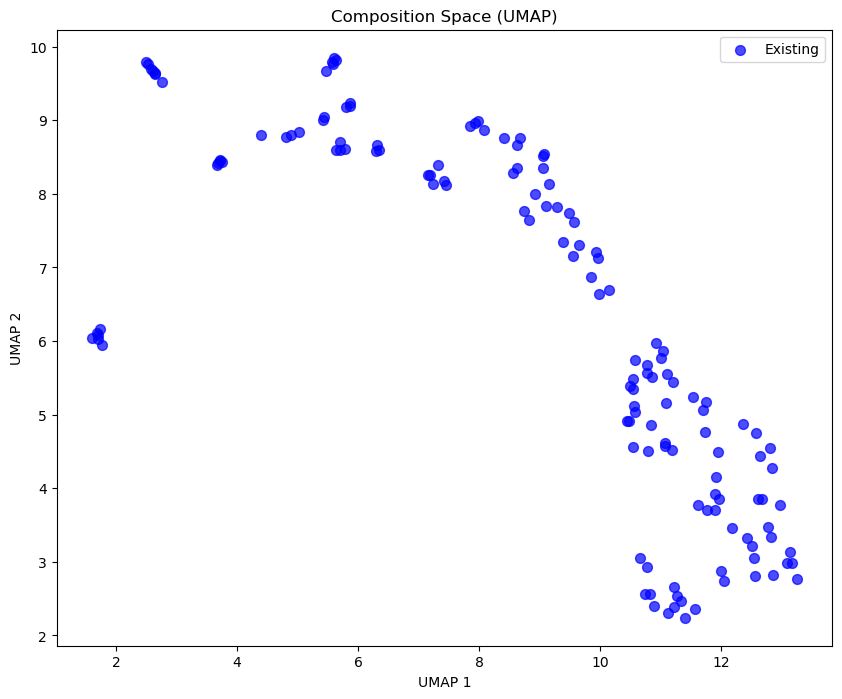

In [4]:
# 3. Visualize the composition space (exclude outliers for clarity).
analyzer.visualize_compositions(embeddings, metadata, outlier_option='exclude')



In [5]:
# 4. Generate new composition suggestions (using only inlier data).
constraints = {
    'V' : (0.8, 0.95),
    'Cr' : (0, 0.1),
    'Ti' : (0, 0.1),
    'W' : (0, 0.1),
    'Zr' : (0, 0.015)
}

suggested = analyzer.suggest_new_compositions(compositions, 
                                              n_suggestions=100, 
                                              metadata=metadata, 
                                              constraints=constraints)
for new_comp in suggested:
    print(new_comp)


{'Cr': 0.03086298248542027, 'Ti': 0.024193548387096774, 'V': 0.8860076682180599, 'W': 0.05226636681109953, 'Zr': 0.006669434098323498}
{'Cr': 0.07537318957138858, 'Ti': 0.02362212414819517, 'V': 0.8260737673791098, 'W': 0.059944735121045215, 'Zr': 0.014986183780261304}
{'Cr': 0.09009663587128998, 'Ti': 0.018290354501166332, 'V': 0.8267096986997023, 'W': 0.05270974126039718, 'Zr': 0.012193569667444221}
{'Cr': 0.011040008904063536, 'Ti': 0.09336771967532503, 'V': 0.884552262516548, 'W': 0.009200007420052947, 'Zr': 0.0018400014840105894}
{'Cr': 0.004460255557872804, 'Ti': 0.08064516129032258, 'V': 0.9044873201834347, 'W': 0.002973503705248536, 'Zr': 0.0074337592631213405}
{'Cr': 0.04593217962268384, 'Ti': 0.06150675311420431, 'V': 0.8772503407222172, 'W': 0.007655363270447307, 'Zr': 0.007655363270447307}
{'Cr': 0.04610276538050087, 'Ti': 0.03240950475962331, 'V': 0.8810137089712202, 'W': 0.03225806451612903, 'Zr': 0.008215956372526536}
{'Cr': 0.0, 'Ti': 0.0796638782834934, 'V': 0.91788291

In [6]:
# 3. Process the new compositions and label them as "new"
new_embeddings, new_clusters, new_metadata = analyzer.reduce_and_cluster(
    suggested,
    n_clusters=10,
    comp_type='new'  # Mark these in the metadata as "new"
)

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
# 4. Combine the embeddings and metadata so that both types appear in the same space
combined_embeddings = np.vstack([embeddings, new_embeddings])
combined_metadata = metadata + new_metadata

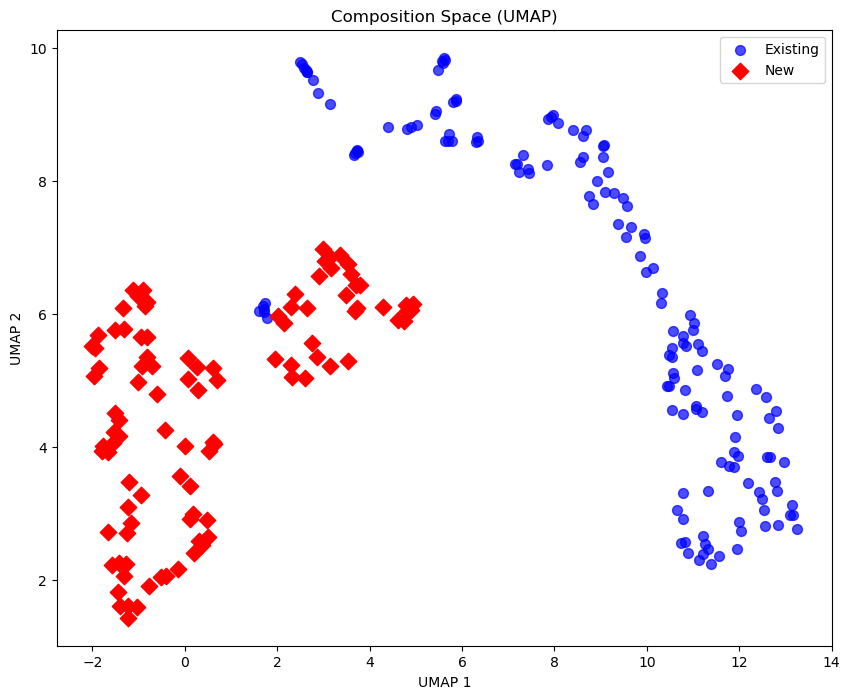

In [8]:
# 5. Visualize the combined composition space.
#    The visualize_compositions method will automatically plot "existing" and "new"
#    compositions differently (using different markers/colors).
analyzer.visualize_compositions(
    combined_embeddings,
    combined_metadata,
    outlier_option='include',  # You can change this to 'exclude' or 'only' as needed.
    save_path=None  # Set a file path to save the plot if desired; else, it will display.
)

## Analyze the new compositions

/opt/homebrew/Caskroom/miniforge/base/envs/mace/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Distance Statistics:
Existing Compositions:
  Mean: 3.708, Median: 3.439, Std: 1.414

Top Novel Compositions:

Rank #1: Cr0.046-Ti0.032-V0.881-W0.032-Zr0.008
  Suggested
  Novelty Score: 0.798
  Distance: 4.577 (percentile: 75.2%)
  LOF Score: 1.104
  Diversity: 0.522
  Composition: Cr: 0.046, Ti: 0.032, V: 0.881, W: 0.032, Zr: 0.008

Rank #2: Cr0.014-Ti0.084-V0.875-W0.020-Zr0.007
  Suggested
  Novelty Score: 0.647
  Distance: 6.630 (percentile: 97.3%)
  LOF Score: 1.084
  Diversity: 0.409
  Composition: Cr: 0.014, Ti: 0.084, V: 0.875, W: 0.020, Zr: 0.007

Rank #3: Cr0.030-Ti0.096-V0.864-W0.005-Zr0.005
  Suggested
  Novelty Score: 0.640
  Distance: 6.359 (percentile: 96.6%)
  LOF Score: 2.161
  Diversity: 0.285
  Composition: Cr: 0.030, Ti: 0.096, V: 0.864, W: 0.005, Zr: 0.005

Rank #4: Cr0.015-Ti0.067-V0.869-W0.042-Zr0.006
  Suggested
  Novelty Score: 0.611
  Distance: 5.687 (percentile: 86.6%)
  LOF Score: 1.465
  Diversity: 0.347
  Composition: Cr: 0.015, Ti: 0.067, V: 0.869, W: 0.

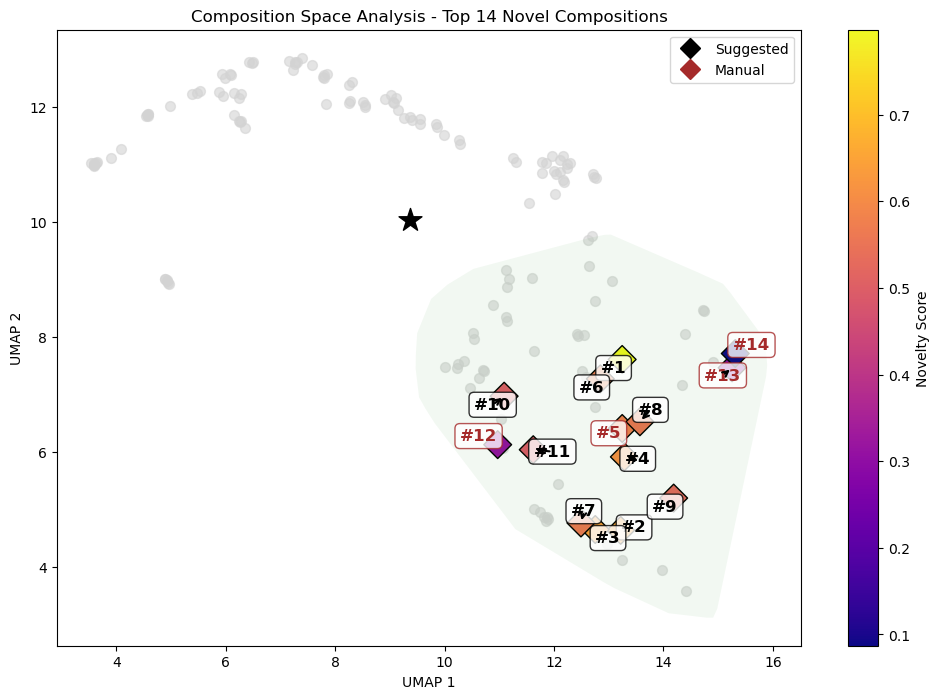

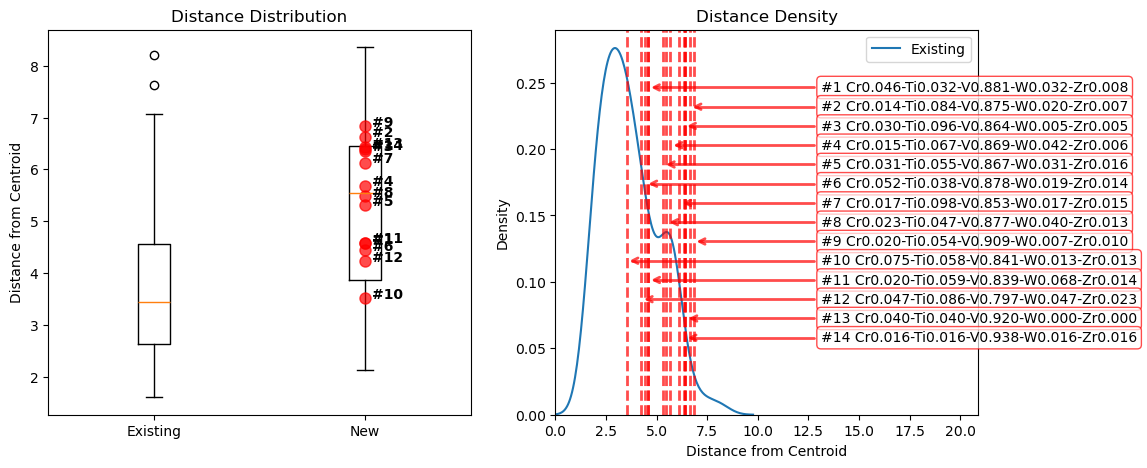

In [10]:
from forge.analysis.composition import analyze_composition_distribution

constraints = {
    'V' : (0.8, 0.95),
    'Cr' : (0, 0.1),
    'Ti' : (0, 0.1),
    'W' : (0, 0.1),
    'Zr' : (0, 0.015)
}

manual_compositions = [
    {"V": 0.92,      "Cr": 0.04,     "Ti": 0.04,     "W": 0.0,      "Zr": 0.0},
    {"V": 0.8671875, "Cr": 0.03125,  "Ti": 0.0546875, "W": 0.03125,  "Zr": 0.015625},
    {"V": 0.9375,    "Cr": 0.015625, "Ti": 0.015625,  "W": 0.015625, "Zr": 0.015625},
    {"V": 0.796875,  "Cr": 0.046875, "Ti": 0.0859375, "W": 0.046875, "Zr": 0.0234375}
]

compare_results = analyze_composition_distribution(analyzer,
                                                    existing_compositions=compositions,
                                                    new_compositions=suggested,
                                                    top_n=10,
                                                    weights=(0.05, 0.2, 0.75),
                                                    manual_compositions=manual_compositions,
                                                    constraint_dict=constraints,
                                                    grid_resolution=10,
                                                    constraint_tol=0.05,
                                                    random_state=seed)

## Make vasp jobs from the best alloys

In [12]:
compare_results['top_compositions'][0]

{'rank': 1,
 'index': 6,
 'composition': {'Cr': 0.04610276538050087,
  'Ti': 0.03240950475962331,
  'V': 0.8810137089712202,
  'W': 0.03225806451612903,
  'Zr': 0.008215956372526536},
 'composition_string': 'Cr0.046-Ti0.032-V0.881-W0.032-Zr0.008',
 'metrics': {'distance': 4.5769963,
  'distance_percentile': 75.16778523489933,
  'lof_score': 1.1038158,
  'diversity': 0.5223879918929841},
 'normalized_metrics': {'distance': 0.3939197,
  'lof_score': 0.14207737,
  'diversity': 0.9999999998067138},
 'novelty_score': 0.7981114609579979,
 'embedding': [13.245794296264648, 7.607248783111572],
 'suggested': True}

In [13]:
best_comp = compare_results['top_compositions'][0]['composition']
best_alloy = analyzer.create_random_alloy(best_comp, 
                             crystal_type='bcc', 
                             dimensions=[5,5,5], 
                             lattice_constant=3.01,
                             balance_element='V',
                             cubic=False)

print(best_alloy)

Atoms(symbols='Cr6Ti5V107W5Zr2', pbc=True, cell=[[-7.5249999999999995, 7.5249999999999995, 7.5249999999999995], [7.5249999999999995, -7.5249999999999995, 7.5249999999999995], [7.5249999999999995, 7.5249999999999995, -7.5249999999999995]])


In [14]:
from ase.io import write
first_picks = []
for i in range(3):
    first_picks.append(analyzer.create_random_alloy(compare_results['top_compositions'][i]['composition'],
                             crystal_type='bcc', 
                             dimensions=[5,5,5], 
                             lattice_constant=3.01,
                             balance_element='V',
                             cubic=False))

write('vcrtiwzr_rank_1_2_3.xyz', first_picks)

Set the Pseupot path

In [19]:
import os 
# Set VASP_PP_PATH
#os.environ["VASP_PP_PATH"] = "/home/myless/Packages/VASP/POTCAR_64_PBE/"
os.environ["VASP_PP_PATH"] = "/Users/myless/Packages/VASP_Learn/ase_potpaw_PBE.64/potpaw_PBE"

In [20]:
from forge.workflows.db_to_vasp import prepare_vasp_job_from_ase
# using the final_diverse_atoms, let's make VASP relaxation jobs for each of them
base_output_dir = '../scratch/data/vasp_jobs-neb-test/perf_t3'
if not os.path.exists(base_output_dir):
    os.makedirs(base_output_dir)

for i,atoms in enumerate(first_picks):
    output_dir = os.path.join(base_output_dir, f'{atoms.get_chemical_formula()}_rank_{i}')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    prepare_vasp_job_from_ase(atoms, 'relaxation', 'PSFC-GPU', output_dir)

[INFO] Created VASP job in ../scratch/data/vasp_jobs-neb-test/perf_t3/Cr6Ti5V107W5Zr2_rank_0 using HPC=PSFC-GPU, VASP=relaxation
[INFO] Created VASP job in ../scratch/data/vasp_jobs-neb-test/perf_t3/Cr2Ti11V108W3Zr_rank_1 using HPC=PSFC-GPU, VASP=relaxation
[INFO] Created VASP job in ../scratch/data/vasp_jobs-neb-test/perf_t3/Cr4Ti12V107WZr_rank_2 using HPC=PSFC-GPU, VASP=relaxation
